# ```uavsar_pytools``` Tutorial

In this notebook, we will display the basic functionality of using ```asf_search``` to find UAVSAR data products, and ```uavsar_pytools``` convert those products in analysis ready GeoTiifs. UAVSAR files come in a flat binary format, which are not ready for analysis. This package allows for the systematic conversion of binary files into GeoTiffs using information from the UAVSAR annoation file.

In [1]:
import asf_search as asf
from uavsar_pytools.UavsarImage import UavsarImage #single image class
from uavsar_pytools.uavsar_tools import grd_tiff_convert #single image class
from uavsar_pytools.UavsarScene import UavsarScene # binary convert to .tiffs
import os  # for chdir, getcwd, path.basename, path.exists
from datetime import datetime
import progressbar
from tqdm import tqdm
import logging
import glob
import requests
import zipfile
#from uavsar_pytools.convert import convert_image
#from uavsar_pytools.download import download_image

# for map to generate wkt
from folium import Map
from folium.plugins import Draw
import geopandas as gpd

# plotting libraries
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import matplotlib.pyplot as plt 

## Finding UAVSAR data

UAVSAR data is located in multiple places online 

## Create Folium map to generate at WKT file

The ```asf_search``` package uses the Well-known text or [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) files to indentify areas of interest (AOI) to search thier database. The [Folium](https://python-visualization.github.io/folium/#:~:text=folium%20makes%20it%20easy%20to,as%20markers%20on%20the%20map.) map created below allows users to generate a WKT by drawing a polygon directly on the map and exporting it to thier local machine. instead of having to write it out by hand. 

Another tool for generating WKT files is the [ASF Vertex](https://search.asf.alaska.edu/#/) platform.

The [UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl) shows the extent of all UAVSAR swaths. This is a good place to start to base your area of interest (AOI) search on using the Folium map.

In [2]:
# show map
m = Map()
draw = Draw(export = True, filename = 'asf_wkt.geojson')
draw.add_to(m)
m

In [4]:
sagehen_wkt = gpd.read_file('/Users/jacktarricone/Downloads/asf_wkt (14).geojson').to_wkt().loc[0, 'geometry']
print(sagehen_wkt)

POLYGON ((-120.235748 39.452101, -120.235748 39.514636, -120.17395 39.514636, -120.17395 39.452101, -120.235748 39.452101))


In [5]:
# define search parameters for sierra flight line
start_date = datetime.strptime('2020-02-14 11:00:00', '%Y-%m-%d %H:%M:%S') 
end_date = datetime.strptime('2020-02-15 11:00:00', '%Y-%m-%d %H:%M:%S') 

## Seach for data
-use asf search, talk about all the parameters that can be used for search
-show different types of processing, state that GRD is important
-

In [6]:
# search for data
results = asf.search(platform = 'UAVSAR',
                     processingLevel = (['INTERFEROMETRY_GRD']),
                     intersectsWith = sagehen_wkt,
                     start = start_date,
                     end = end_date)

print(f'{len(results)} product(s) found')

1 product(s) found


In [7]:
# describe this whole "class" thing...
type(results)

asf_search.ASFSearchResults.ASFSearchResults

In [8]:
# pull out the first result from the list and print it
first = results[0]
print(first.properties)

{'beamModeType': 'RPI', 'browse': ['https://datapool.asf.alaska.edu/BROWSE/UA/donner_03904_20002-003_20009-026_0019d_s01_L090HH_01.cor.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/donner_03904_20002-003_20009-026_0019d_s01_L090HH_01.hgt.png'], 'bytes': '524731624', 'faradayRotation': None, 'fileID': 'UA_donner_03904_20002-003_20009-026_0019d_s01_L090_01-INTERFEROMETRY_GRD', 'fileName': 'donner_03904_20002-003_20009-026_0019d_s01_L090_01_int_grd.zip', 'flightDirection': None, 'frameNumber': '786', 'granuleType': 'UAVSAR_INSAR_SCENE', 'groupID': 'UA_donner_03904_20002-003_20009-026_0019d_s01_L090_01', 'insarStackId': '-1', 'md5sum': '2360c66931e4854785d689e3b286d23a', 'offNadirAngle': None, 'orbit': '-1', 'pathNumber': '03904', 'platform': 'UAVSAR', 'pointingAngle': None, 'polarization': 'HH', 'processingDate': '2021-11-10T01:08:27Z', 'processingLevel': 'INTERFEROMETRY_GRD', 'sceneName': 'UA_donner_03904_20002-003_20009-026_0019d_s01_L090_01', 'sensor': 'UAVSAR', 'startTime': '2020-0

## Define URLs for Download


In [9]:
# define the URLs and print, decribe this functionality is within the ASFproduct class
first_url = first.properties['url']
print(first_url)

https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/donner_03904_20002-003_20009-026_0019d_s01_L090_01_int_grd.zip


In [10]:
# define outpout dir and list files
os.chdir('/Users/jacktarricone/Desktop/zach_test/sagehen/')
output_dir = '/Users/jacktarricone/Desktop/zach_test/sagehen/'

In [12]:
# define image to download
# download_image(url = first_url, output_dir = output_dir)
scene = UavsarScene(url = first_url, work_dir='./data/imgs/')
scene.url_to_tiffs()

Unzipping: 100%|██████████████████████████████| 5/5 [00:09<00:00,  1.94s/file]


# Test Plots
Now that the data has been downloaded and converted to GeoTiffs, let's test plot to make sure everything worked properly.

In [13]:
# search for unw and ann files for download test
# os.chdir('/Users/jacktarricone/Desktop/zach_test/slc/data')
cor = glob.glob(os.path.abspath("data/imgs/tiffs/*HH*cor.grd.tiff"))
print(cor[0])

/Users/jacktarricone/Desktop/zach_test/sagehen/data/imgs/tiffs/donner_03904_20002-003_20009-026_0019d_s01_L090HH_01.cor.grd.tiff


In [14]:
cor_rast = rio.open(cor[0])
meta_data = cor_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10258, 'height': 9663, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -120.67970916,
       0.0, -5.556e-05, 39.56438712), 'tiled': False, 'interleave': 'band'}


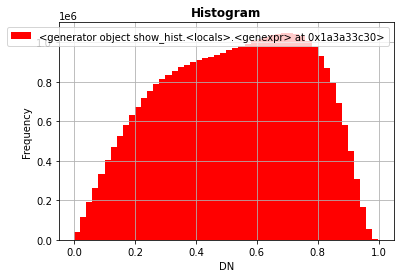

In [15]:
show_hist(cor_rast, bins = 50)

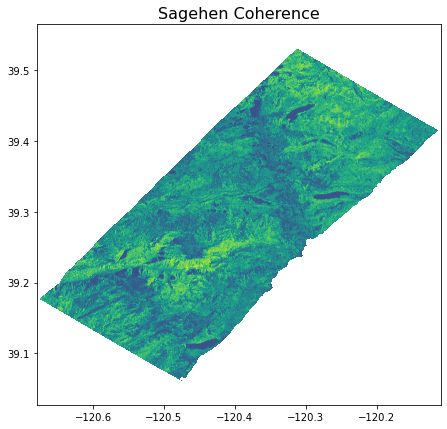

In [19]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Sagehen Coherence",fontsize = 16);
show((cor_rast, 1), cmap = 'viridis'); # info from histogram

/Users/jacktarricone/uavsar_pytools_jack/uavsar_pytools/UavsarImage.py:81: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if self.arr != None:


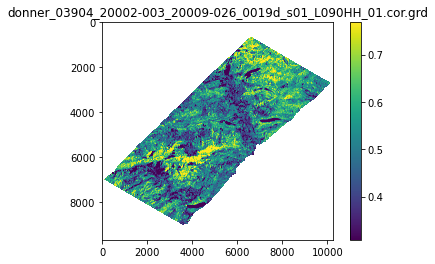

In [18]:
# define outpout dir and list files
os.chdir('/Users/jacktarricone/Desktop/zach_test/single/')
single_url = 'http://uavsar.asfdaac.alaska.edu/UA_donner_03904_20002-003_20009-026_0019d_s01_L090_01/donner_03904_20002-003_20009-026_0019d_s01_L090HH_01.cor.grd'
image = UavsarImage(url = single_url, work_dir = './data/imgs/')
image.url_to_tiff()
image.show()